In [3]:
import pandas as pd
import numpy as np
import itertools
import psutil
import warnings
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import joblib                       # para guardar/cargar modelos

warnings.filterwarnings("ignore")

# ------------------------------------------------------------------
# 1) CONFIGURACIÓN
# ------------------------------------------------------------------
FILE = r'/home/cony/Documentos/Cony/trabajo_final/datos_sla_y_era_ok.csv'
STEP_DIFF = 1440
LAGS = 0
RUTA_BEST = 'sarimax_diff_best.pkl'


# ------------------------------------------------------------------
# 2) CARGA Y DIFERENCIACIÓN
# ------------------------------------------------------------------
df = (pd.read_csv(FILE, parse_dates=['date'])
        .set_index('date')
        .asfreq('1min')
        .interpolate('time')
        .dropna())

# Diferenciar la variable objetivo
# Diferenciamos AMBAS series
df_diff = pd.DataFrame(index=df.index)
df_diff['delta_obs'] = df['Temp'].diff(STEP_DIFF)   # target
df_diff['delta_era'] = df['t2m'].diff(STEP_DIFF) # exógena
df_diff = df_diff.dropna()


# ------------------------------------------------------------------
# 3) CORTE TEMPORAL
# ------------------------------------------------------------------
TOTAL = len(df_diff)
train_end = int(0.70 * TOTAL)
val_end   = int(0.85 * TOTAL)

train = df_diff.iloc[:train_end]
val   = df_diff.iloc[train_end:val_end]
test  = df_diff.iloc[val_end:]

print(f"Total: {TOTAL} | Train: {len(train)} | Val: {len(val)} | Test: {len(test)}")


Total: 764679 | Train: 535275 | Val: 114702 | Test: 114702


In [ ]:
# ------------------------------------------------------------------
# 4) GRID Y ENTRENAMIENTO (igual que tu script original)
# ------------------------------------------------------------------

COLUMNA_OBJ = 'delta_obs'   # ya no es Temp, es la diferencia
EXOG_COL    = 'delta_era'   # ahora es la diferencia de ERA5

p = q = range(0, 3)
d = [0, 1]
seasonal_pdq = [(x[0], x[1], x[2], 0) for x in itertools.product(p, d, q)]

best_mse   = np.inf
best_order = None
best_model = None
history    = []

for order in itertools.product(p, d, q):
    for seasonal_order in seasonal_pdq:
        try:
            proc       = psutil.Process()
            mem_before = proc.memory_info().rss / (1024 ** 2)

            model = SARIMAX(train[COLUMNA_OBJ],
                            exog=train[[EXOG_COL]],   # siempre lista
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)

            res = model.fit(disp=False)

            forecast = res.forecast(steps=len(val),
                                    exog=val[[EXOG_COL]])

            mem_after = proc.memory_info().rss / (1024 ** 2)
            peak_mem  = max(mem_before, mem_after)
            mse = mean_squared_error(val[COLUMNA_OBJ], forecast)

            history.append((order, seasonal_order, mse))
            print(f"{order}x{seasonal_order}  MSE={mse:.4f}  RAM={peak_mem:.1f} MiB")

            if mse < best_mse:
                best_mse, best_order, best_model = mse, (order, seasonal_order), res

        except Exception as e:
            continue

print("\n✅ Mejor modelo (sobre diferencia diaria):")
print(best_model.summary())


MODEL_PATH = 'srimax_diff.pkl'
joblib.dump(best_model, MODEL_PATH)
print(f"Modelo guardado en {MODEL_PATH}")

In [15]:
import pandas as pd, matplotlib.pyplot as plt, sys
ruta_directorio = r'/home/cony/Documentos/GEERS/codigos_pc'
sys.path.append(ruta_directorio)
import Metrics as m

# --- funciones limpias -------------------------------------------
def plots(x, y_original, y_estimado, serie1='serie', serie2='serie'):
    plt.figure(figsize=(14,4))
    plt.plot(x, y_original, label=f'{serie1} ')
    plt.plot(x, y_estimado, label=f'{serie2} ')
    plt.xlabel('Etiqueta temporal', fontsize=15)
    plt.ylabel('T (°C)', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=20)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

def calculo_m(true, pred):
    rmbe  = m.rmbe(true, pred)
    rrmsd = m.rrmsd(true, pred)
    rmae  = m.rmae(true, pred)
    return rmbe, rrmsd, rmae



=== TEST (reconstruido) ===
rMBE:  0.3891%
rRMSD: 14.3396%
rMAE:  11.1163%


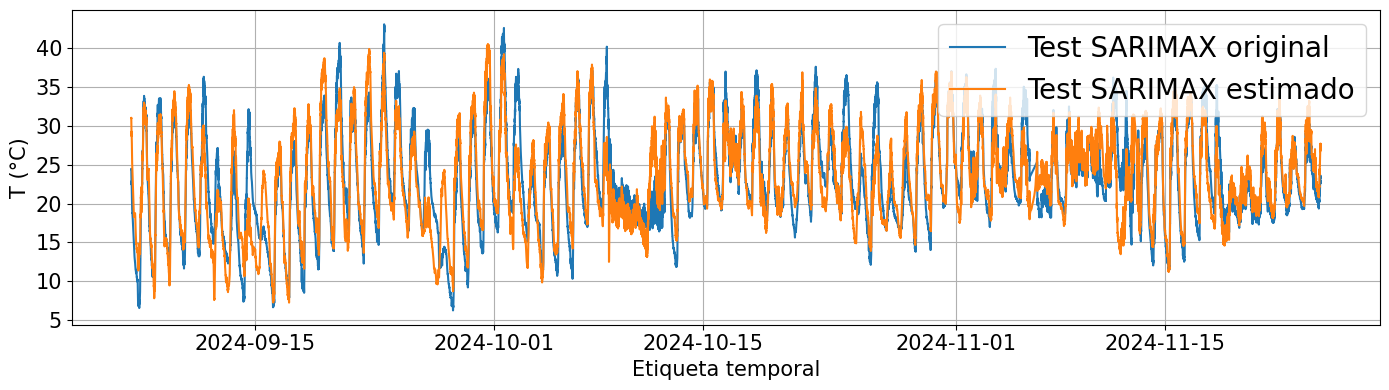

In [5]:

# ------------------------------------------------------------------
# 5) RECONSTRUCCIÓN A NIVELES
# ------------------------------------------------------------------

# saltar los pasos que ya usaste en val
best_model = joblib.load('srimax_diff.pkl')

skip = len(val)

base_levels = df['Temp'].shift(STEP_DIFF).reindex(test.index)

pred_full = best_model.forecast(steps=len(val)+len(test),
                                exog=pd.concat([val, test])[['delta_era']])

test_forecast = pred_full.iloc[skip:]

pred_levels = base_levels + test_forecast

y_true = base_levels
y_pred = pred_levels

# Métricas
rmse_test, rrmsd_test, rmae_test = calculo_m(y_true, y_pred)
print("\n=== TEST (reconstruido) ===")
print(f"rMBE:  {rmse_test:.4f}%")
print(f"rRMSD: {rrmsd_test:.4f}%")
print(f"rMAE:  {rmae_test:.4f}%")

# Gráfico
plots(y_true.index, y_true, y_pred, serie='Test SARIMAX')


=== TRAIN (reconstruido) ===
rMBE:  0.1481%
rRMSD: 21.6195%
rMAE:  15.4464%


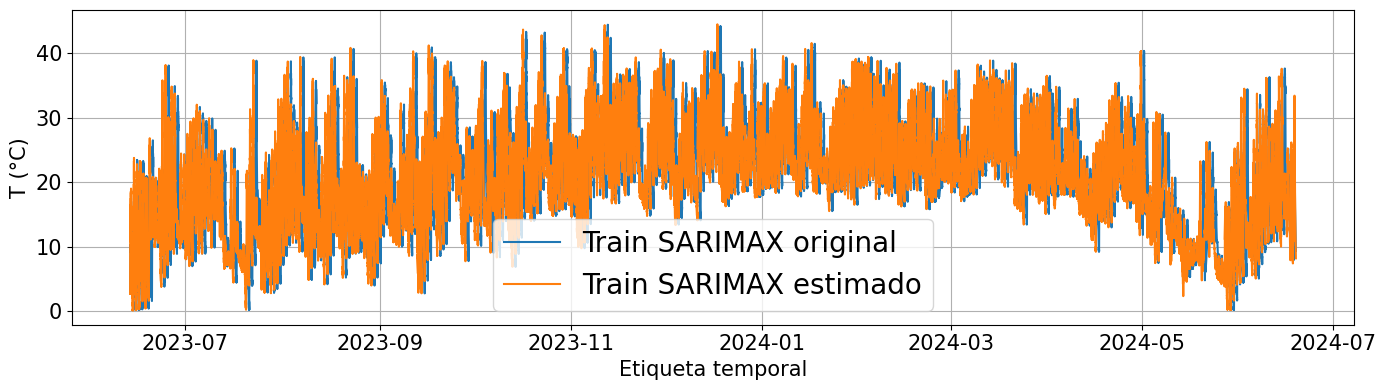

In [6]:
# predicción dentro-muestra sobre train
delta_pred_train = best_model.predict()       # uso lo que el modelo ya calculo al entrenarse
base_train       = df['Temp'].shift(STEP_DIFF).loc[train.index]

train_pred = base_train + delta_pred_train

y_true_train = base_train
y_pred_train = train_pred

# Métricas
rrmbe_train, rrmsd_train, rmae_train = calculo_m(y_true_train, y_pred_train)

print("\n=== TRAIN (reconstruido) ===")
print(f"rMBE:  {rrmbe_train:.4f}%")
print(f"rRMSD: {rrmsd_train:.4f}%")
print(f"rMAE:  {rmae_train:.4f}%")

plots(y_true_train.index, y_true_train, y_pred_train, serie='Train SARIMAX')

In [16]:

# --- Datos crudos (no diferenciados) alineados temporalmente

y_true_orig = df.loc[test.index, 'Temp']          # mediciones
y_pred_orig = df.loc[test.index, 't2m']           # ERA-5 sin ajuste

%matplotlib  qt

# Métricas
rrmbe_orig, rrmsd_orig, rmae_orig = calculo_m(y_true_orig, y_pred_orig)

print("\n=== TEST (Original) ===")
print(f"rMBE:  {rrmbe_orig:.4f}%")
print(f"rRMSD: {rrmsd_orig:.4f}%")
print(f"rMAE:  {rmae_orig:.4f}%")

plots(y_true_orig.index, y_true_orig, y_pred_orig, serie1='T_amb', serie2='T_era5')


=== TEST (Original) ===
rMBE:  -28.2714%
rRMSD: 30.3375%
rMAE:  28.3055%
